# HW 1 Базовые методы RL

**Задача:** найти оптимальную стратегию перемещения таксиста по городу Новинск, используя марковский процесс принятия решений.

**Описание.** В городе Новинске таксист ездит по решетчатому участку, состоящему из 5x5 ячеек. Он может перемещаться на одну ячейку вверх, вниз, влево или вправо (если не находится на границе). В определенных ячейках находятся пассажиры, а в других ячейках — места назначения.

**Детали:**


*   Всего 4 возможных места, где может находиться пассажир (A, B, C, D).
*   Есть 4 соответствующих места назначения (a, b, c, d).
*   Пассажир может находиться в любом из четырех мест (A, B, C, D) и желать доехать до любого из четырех мест назначения.
*   Таксист получает +10 очков за каждого успешно доставленного пассажира до его пункта назначения и -1 за каждое движение. Если таксист приезжает на ячейку с пассажиром, он автоматически забирает его.

**Описание задание как марковского процесса принятия решений (МППР)**

# Описание задание как марковского процесса принятия решений (МППР)

Марковские процессы принятия решений представляют собой инструмент для постановки задачи обучения, где достижение цели осуществляется через взаимодействие и последовательное принятие решений. Окружающая среда (или просто среда), представляет собой сторону, с которой взаимодействует агент. Агент выбирает действия, в то время как среда реагирует на эти действия и предоставляет новые ситуации для агента.

Формально МППР представляет из себя кортеж из 4-х значений (S,A,R,P), где:

* **S** – все возможные состояния среды. В учебном примере, состояние представляет из себя комбинацию положения такси (5 столбцов * 5 строк для поля размером 5х5 = 25 возможных вариантов), 5 возможных положений пассажира (в одной из определённых локаций (A, B, C, D) или внутри такси в пути) и 4 возможных локации места назначения (a, b, c, d). Итого кол-во состояний среды может быть в 500 вариантах (25х5х4)
* **A** – все возможные действия агента. В данной учебной задаче возможные действия агента включают (указывается число, которые будет использоваться в коду и описания, которое будет использоваться в визуализации):

      -    0: move down
      -	1: move up
      -	2: move right
      -	3: move left
      -	4: pickup passenger
      -	5: dropoff passenger



*   **R** – система вознаграждений/наград включает следующее:

        +10 очков за каждого успешно доставленного пассажира до его пункта назначения
        -1 за каждое движение
        -10 за drop off в неправильном месте
        -10 если есть action pick up в локации без пассажира



*   **P** – матрица распределения вероятностей/матрица перехода, представляющая из себя вероятности, что одно из возможных состояний будет следующим новым состоянием при получении конкретных состояний и действий в момент времени t. В данной задаче эта матрица инициализируется при задании среды и представляет их себя словарь, длиной в количество состояний, где каждая запись в словаре – список по кол-ву действий. При инициализации данная матрица заполняется пустыми значениями, по мере прохождения игры значения в этой матрице обновляются.

Загрузим необходимые библиотеки. После установки потребуется еще раз перезапустить ноутбук для установки библиотек.

In [1]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [2]:
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import gym
import math
from matplotlib import rc
import sys
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.registration import register
from gym.envs.toy_text.utils import categorical_sample
import time
from IPython.display import clear_output
from scipy.signal import savgol_filter
from typing import Optional
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.3)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# Environment

В основе кода для среды я использую код из репозитория gym для среды Taxi [ссылка здесь](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py). В него добавила отделение мест нахождения пассажиров от мест назначения (в изначальном варианте они совпадают и не стала брать рендеринг в картинку, использую вариант представления среды в виде текста.

Как пишу в пояснении к классу пассажир, может находиться на одном из определенных рандомно мест из списка, также рандомно определяется его место назначение из 4-х предложенных. В момент времени t в игре всего 1 пассажир.

Ниже опредделяю класс для среды и регистрирую его в gym, чтобы потом использовать для обучения.

In [3]:
MAP = [
    "+---------+",
    "|a: :A: :b|",
    "| : : : : |",
    "| :B:C: : |",
    "| : : : : |",
    "|c: :D:d: |",
    "+---------+",
]


class KateCab(gym.Env):
    """
    Modified Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich

    Description:
    There are four designated locations in the grid world (a,b,c,d). When the episode starts, the taxi starts off at a random square and the passenger is at a random location.
    The taxi drive to the passenger's location, pick up the passenger, drive to the passenger's destination (another one of the four specified locations), and then drop off the passenger.
    Once the passenger is dropped off, the episode ends.

    Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is the taxi), and 4 destination locations.

    Actions:
    There are 6 discrete deterministic actions:
    - 0: move down
    - 1: move up
    - 2: move right
    - 3: move left
    - 4: pickup passenger
    - 5: dropoff passenger

    Rewards:
    There is a reward of -1 for each action and an additional reward of +10 for delievering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.

    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (a, b, c, d -destinations; A, B, C, D - passenger locations): locations for passengers and destinations

    actions:
    - 0: down
    - 1: up
    - 2: right
    - 3: left
    - 4: pickup
    - 5: dropoff

    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """
    metadata = {'render_modes': ['human', 'ansi', 'rgb_array'],
                "render_fps": 4}

    def __init__(self, render_mode: Optional[str] = None):
        self.desc = np.asarray(MAP, dtype='c')

        self.locs = locs = [(0,0), (0,4), (4,0), (4,3)]
        self.passenger_locs = p_locs= [(0,2), (2,1), (2,2), (4,2)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        self.initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        self.P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            self.initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1 # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2:
                                new_col = min(col + 1, max_col)
                            elif action == 3:
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and taxi_loc == p_locs[pass_idx]): # думаю здесь можно прописать ссылку на местоположение пассажира
                                    new_pass_idx = 4
                                else: # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 10
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else: # dropoff at wrong location
                                    reward = -10

                            new_loc = (new_row, new_col)

                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx)
                            self.P[state][action].append(
                                (1.0, new_state, reward, done))
        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.action_space = gym.spaces.Discrete(num_actions)
        self.observation_space = gym.spaces.Discrete(num_states)


    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def action_mask(self, state: int):
        """Computes an action mask for the action space using the state information."""
        mask = np.zeros(6, dtype=np.int8)
        taxi_row, taxi_col, pass_loc, dest_idx = self.decode(state)
        if taxi_row < 4:
            mask[0] = 1
        if taxi_row > 0:
            mask[1] = 1
        if taxi_col < 4 and self.desc[taxi_row + 1, 2 * taxi_col + 2] == b":":
            mask[2] = 1
        if taxi_col > 0 and self.desc[taxi_row + 1, 2 * taxi_col] == b":":
            mask[3] = 1
        if pass_loc < 4 and (taxi_row, taxi_col) == self.passenger_locs[pass_loc]:
            mask[4] = 1
        if pass_loc == 4 and (
            (taxi_row, taxi_col) == self.locs[dest_idx]
            or (taxi_row, taxi_col) in self.locs
        ):
            mask[5] = 1
        return mask

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p, "action_mask": self.action_mask(s)})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None
        self.taxi_orientation = 0

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1.0, "action_mask": self.action_mask(self.s)}

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout
        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x

        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = gym.utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], 'yellow', highlight=True)
            pi, pj = self.passenger_locs[pass_idx] # passenger location
            out[1 + pi][2 * pj + 1] = gym.utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = gym.utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = gym.utils.colorize(out[1 + di][2 * dj + 1], 'magenta')

        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Down", "Up", "Right", "Left", "Pickup", "Dropoff"][self.lastaction]))
        else: outfile.write("\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()

register(
    id='KateCab-v0',
    entry_point=f"{__name__}:KateCab",
    max_episode_steps=250,
)

In [4]:
env = gym.make('KateCab-v0', new_step_api=True)

In [5]:
env.reset()
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


Как видно на рисунке выше, среда отрисовалась. Желтым цветом обозгачено пустое такси, синим цветом - местоположение пассажира и бордовым цветом - пункт назначения. Также вывела на печать все действия в среде и кол-во ее состояний. Вроде бы все готово для обучения.


# Обучение Cross_entropy

В качестве итеративного методоа обучения выберу кросс-энтропию, которую мы рабирали на семинаре. Ниже определения:

**Итеративный метод** - это метод, который повторяет процесс обучения несколько раз, чтобы улучшить результаты. В обучении с подкреплением, итеративные методы обычно используются для улучшения качества обучения агента.

**Кросс-энтропия** - это метод, который используется для обучения агента в среде с несколькими состояниями. Он основан на принципе максимизации кросс-энтропии между действиями агента и его оценками.



# Training


Инициализирую стратегию предложенной на занятии "равномерной" стратегией

In [7]:
def initialize_policy(n_states, n_actions):
    """<codehere>"""
    policy = np.full((n_states, n_actions), 1. / n_actions)
    """</codehere>"""
    return policy

n_states  = env.observation_space.n
n_actions = env.action_space.n
policy = initialize_policy(n_states, n_actions)

In [8]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

In [9]:
def generate_session(env, policy, t_max=10**4):
    """
    Игра идет до конца эпизода или до t_max шагов в окружении.
    :param policy: [n_states,n_actions]
    :returns: states - список состояний, actions - список действий, session_return - итоговая отдача
    """
    states, actions = [], []
    session_return = 0.

    s, info = env.reset()
    action_mask = np.full(n_actions,1)
    for t in range(t_max):
        # Подсказка: вы можете использовать `np.random.default_rng().choice`
        # для сэмплирования
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html
        # a =
        """<codehere>"""
        prob = policy[s] * action_mask
        prob = prob/  prob.sum()
        a = np.random.default_rng().choice(n_actions, p=prob)
        """</codehere>"""
        new_s, r, terminated, truncated, info = env.step(a)

        action_mask = info['action_mask']
        #{'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)})

        # Записываем информацию, который мы получили от среды.
        states.append(s)
        actions.append(a)
        session_return += r

        s = new_s
        if terminated:
            break

    return states, actions, session_return

In [10]:
s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert isinstance(r, float)

In [11]:
def select_elites(states_batch, actions_batch,
                  returns_batch, percentile=50):
    """
    Выбирает состояния и действия с заданным перцентилем (rewards >= percentile)
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of session returns, returns_batch[session_i]

    :returns: elite_states, elite_actions - одномерные
    списки состояния и действия, выбранных сессий
    """
    # нужно найти порог вознаграждения по процентилю
    # reward_threshold =
    """<codehere>"""
    return_threshold = np.percentile(returns_batch, percentile)
    """</codehere>"""


    # в соответствии с найденным порогом - заполнить списки
    # elite_states и elite_actions, нужными состояниями и действиями
    elite_states = []
    elite_actions = []
    """<codehere>"""
    for index, session_return in enumerate(returns_batch):
        if session_return >= return_threshold:
            elite_states += states_batch[index]
            elite_actions += actions_batch[index]
    """</codehere>"""

    return elite_states, elite_actions

In [12]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
returns_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, returns_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, returns_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, returns_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, returns_batch, percentile=100)

assert np.all(
    test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) \
       and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]), \
    "Для процентиля 0 необходимо выбрать все состояния " \
    "и действия в хронологическом порядке"

assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1])\
   and np.all(test_result_30[1] == [3, 2, 0, 1, 3, 3]), \
    "Для процентиля 30 необходимо выбрать " \
    "состояния/действия из [3:]"
assert np.all(test_result_90[0] == [3, 1]) and \
       np.all(test_result_90[1] == [3, 3]), \
    "Для процентиля 90 необходимо выбрать состояния " \
    "действия одной игры"
assert np.all(test_result_100[0] == [3, 1]) and \
       np.all(test_result_100[1] == [3, 3]), \
    "Проверьте использование знаков: >=,  >. " \
    "Также проверьте расчет процентиля"
print("Тесты пройдены!")


Тесты пройдены!


In [13]:
def update_policy(elite_states,elite_actions):
    """
    Новой стратегией будет:
    policy[s_i,a_i] ~ #[вхождения  si/ai в лучшие states/actions]

    Не забудьте про нормализацию состояний.
    Если какое-то состояние не было посещено,
    то используйте равномерное распределение 1./n_actions

    :param elite_states:  список состояний
    :param elite_actions: список действий
    """
    new_policy = np.zeros([n_states,n_actions])

    # обновляем стратегию - нормируем новые частоты
    # действий и не забываем про непосещенные состояния
    """<codehere>"""
    for state, action in zip(elite_states, elite_actions):
        new_policy[state][action] += 1

    for state in range(len(new_policy)):
        s = np.sum(new_policy[state])
        if s == 0:
            new_policy[state, :] = 1. / n_actions # равномерно выбираем действия
        else:
            new_policy[state, :] /= s #увеличиваем вероятность просемплировать те действия, которые приносили успех
    """</codehere>"""
    return new_policy

In [14]:
elite_states, elite_actions = (
    [1, 2, 3, 4, 2, 0, 2, 3, 1],
    [0, 2, 4, 3, 2, 0, 1, 3, 3])

new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(
    new_policy).all(), "Стратегия не должна содержать " \
                       "NaNs или +-inf. Проверьте " \
                       "деление на ноль. "
assert np.all(
    new_policy >= 0), "Стратегия не должна содержать " \
                      "отрицательных вероятностей "
assert np.allclose(new_policy.sum(axis=-1),
                   1), "Суммарная\ вероятность действий"\
                       "для состояния должна равняться 1"
reference_answer = np.array([
    [1., 0., 0., 0., 0.],
    [0.5, 0., 0., 0.5, 0.],
    [0., 0.33333333, 0.66666667, 0., 0.],
    [0., 0., 0., 0.5, 0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Тесты пройдены!")

Тесты пройдены!


In [15]:
from IPython.display import clear_output

def show_progress(returns_batch, log, percentile, return_range=[-990, +10]):
    """
    Удобная функция, для визуализации результатов.
    """

    mean_return = np.mean(returns_batch)
    threshold = np.percentile(returns_batch, percentile)
    log.append([mean_return, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean returns')
    plt.plot(list(zip(*log))[1], label='Return thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(returns_batch, range=return_range)
    plt.vlines([np.percentile(returns_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean return = %.3f, threshold=%.3f" % (mean_return, threshold))
    plt.show()

In [18]:
# инициализируем стратегию
policy = initialize_policy(n_states, n_actions)

Как раз само обучение. Запускала его несколько раз, чтобы получить максимально оптимальный вариант, где оба графика максимально близки друг к другу. Если судить по графику ниже, вроде бы получилось неплохо.

mean return = -7.200, threshold=-1.000


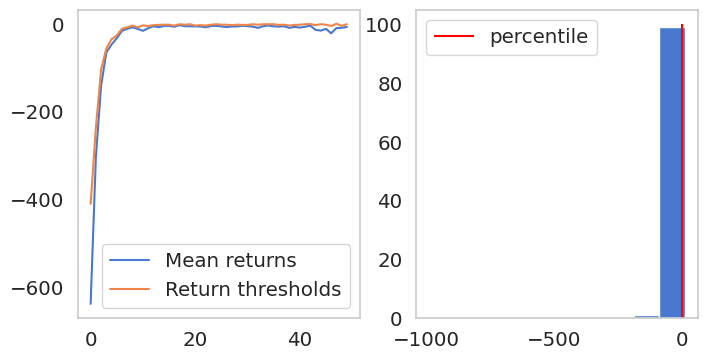

In [19]:
from tqdm.notebook import tqdm
n_sessions = 100  # количество сессий для сэмплирования
percentile = 50  # перцентиль
learning_rate = 0.5 # то как быстро стратегия будет обновляться


log = []

for i in tqdm(range(50)):
    # генерируем n_sessions сессий
    # sessions = []
    """<codehere>"""
    sessions = [generate_session(env, policy) for _ in range(n_sessions)]
    """</codehere>"""

    states_batch, actions_batch, returns_batch = zip(*sessions)
    # отбираем лучшие действия и состояния ###
    # elite_states, elite_actions =
    """<codehere>"""
    elite_states, elite_actions = select_elites(
        states_batch, actions_batch, returns_batch, percentile
    )
    """</codehere>"""

    # обновляем стратегию
    # new_policy =
    """<codehere>"""
    new_policy = update_policy(elite_states, elite_actions)
    """</codehere>"""

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # выводим график с результатами
    show_progress(returns_batch, log, percentile)

# Инференс

In [20]:
final_session = generate_session(env, policy)

Подготовим функцию, которая будет отрисовывать состояние среды по шагам, так как среда только в виде текста записать видое с ней как на семинаре я не могу.

In [38]:
def print_frames(frames):
  for i, frame in enumerate(frames):
    clear_output(wait=True)
    print(frame['frame'])
    print(f"Episode: {frame['episode']}")
    print(f"Timestep: {frame['step']}")
    print(f"State: {frame['state']}")
    print(f"Reward: {frame['reward']}")
    time.sleep(0.1)

Посмотрим как будет вести себя среда на тестовых эпизодах. Один эпизод - это действия агента от инициализации участников на поле до dropp off пассажира в месет назначения. Посомтрим, какую награду будет набирать агент -> чем выше значение больше 0, тем меньше шагов сделал агент для доставки пассажира

In [53]:
total_test_episodes = 20

frames = []
rewards = []

for episode in range(total_test_episodes):
    state, _= env.reset()
    episode_rewards = []

    step = 1

    while True:
        action = np.random.default_rng().choice(n_actions, p=policy[state])
        new_state, reward, terminated, truncated, info = env.step(action)

        frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'episode': episode + 1,
          'step': step,
          'reward': reward
        })

        episode_rewards.append(reward)

        if terminated:
            step = 0
            break
        state = new_state
        step += 1

    rewards.append(np.sum(episode_rewards))

env.close()

Отрисую га графике суммарное вознаграждение за эпизод - видно, что из 20 тестовых эпизодов 10 и 16 - вообще не удачные. Остальные вроде бы ничего. В целом стратегия кросс-энтропии считается максимально простой и менее эффективной

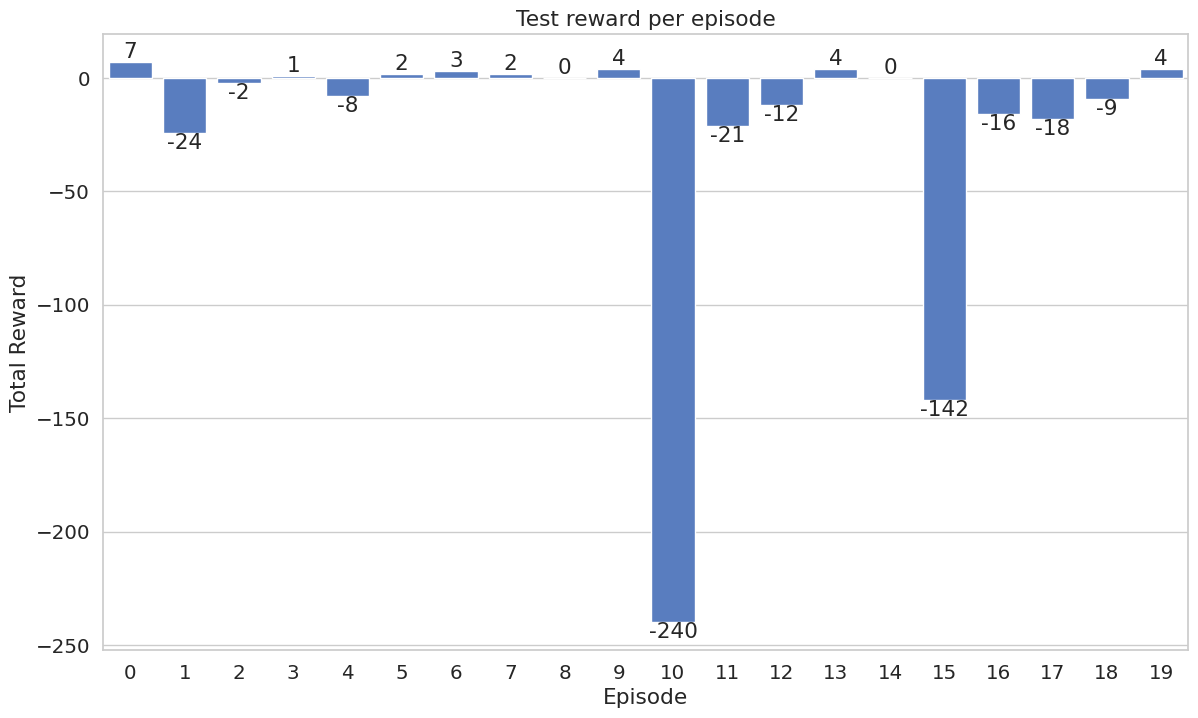

In [55]:
ax = sns.barplot(x=np.arange(len(rewards)), y=rewards)
ax.bar_label(ax.containers[0])
plt.title("Test reward per episode")
plt.xlabel('Episode');
plt.ylabel('Total Reward');

Используя подготовленную функцию можно отрисовать эпизоды последовательно, имитируя видео.

In [56]:
print_frames(frames)

+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Dropoff)

Episode: 20
Timestep: 7
State: 16
Reward: 10


Посмотрим на несклько эпизодов отдельно. Для этого распечатаю каждый эпизод.

Эпизод 1 - он достаточно удачный, так как такси оказалось в той же локации, что и пассажир.

In [59]:
print(f'Steps in episode: {len([item for item in frames if item["episode"] == 1])}')

for i, frame in enumerate([item for item in frames if item["episode"] == 1]):
  #clear_output(wait=True)
  print(frame['frame'])
  print(f"Episode: {frame['episode']}")
  print(f"Timestep: {frame['step']}")
  print(f"State: {frame['state']}")
  print(f"Reward: {frame['reward']}")

Steps in episode: 4
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Pickup)

Episode: 1
Timestep: 1
State: 41
Reward: -1
+---------+
|a: :A:_:b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Right)

Episode: 1
Timestep: 2
State: 57
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Right)

Episode: 1
Timestep: 3
State: 77
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Dropoff)

Episode: 1
Timestep: 4
State: 97
Reward: 10


Обращаю внимание, что так как это второй эпизод, то он стартует с последним тегом действия из предыдущего эпизода.

Со эпизодом 2 ситуация хуже - в нем уже 17 шагов, есть аж 2 drop off  в локации, при это в такси не было пассажира (step 2 + step 3), потом немного мельтешения, но такси все-таки доехало до пассажира и  довезло до локации

In [60]:
print(f'Steps in episode: {len([item for item in frames if item["episode"] == 2])}')
for i, frame in enumerate([item for item in frames if item["episode"] == 2]):
  #clear_output(wait=True)
  print(frame['frame'])
  print(f"Episode: {frame['episode']}")
  print(f"Timestep: {frame['step']}")
  print(f"State: {frame['state']}")
  print(f"Reward: {frame['reward']}")

Steps in episode: 17
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Left)

Episode: 2
Timestep: 1
State: 8
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Dropoff)

Episode: 2
Timestep: 2
State: 8
Reward: -10
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Dropoff)

Episode: 2
Timestep: 3
State: 8
Reward: -10
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Down)

Episode: 2
Timestep: 4
State: 8
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Right)

Episode: 2
Timestep: 5
State: 108
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Up)

Episode: 2
Timestep: 6
State: 128
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Right)

Episode: 2
Timestep: 7
State: 28
Reward: -1
+------

Третий эпизод уже лучше, нет неправильных pick up + drop off, есть немного неправильных ходов, но такси все-таки забирает пассажира и отвозит до локации.

In [61]:
print(f'Steps in episode: {len([item for item in frames if item["episode"] == 3])}')
for i, frame in enumerate([item for item in frames if item["episode"] == 3]):
  #clear_output(wait=True)
  print(frame['frame'])
  print(f"Episode: {frame['episode']}")
  print(f"Timestep: {frame['step']}")
  print(f"State: {frame['state']}")
  print(f"Reward: {frame['reward']}")

Steps in episode: 13
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Up)

Episode: 3
Timestep: 1
State: 461
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Left)

Episode: 3
Timestep: 2
State: 361
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Left)

Episode: 3
Timestep: 3
State: 341
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Up)

Episode: 3
Timestep: 4
State: 321
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Up)

Episode: 3
Timestep: 5
State: 221
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Left)

Episode: 3
Timestep: 6
State: 121
Reward: -1
+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+
  (Up)

Episode: 3
Timestep: 7
State: 101
Reward: -1
+---------+
|a